## Basic GAN Implementation

We will attempt to generate samples from MNIST dataset using GAN.

This is an attempt to implement the original paper on GAN (https://arxiv.org/pdf/1406.2661.pdf)

In [1]:
#Import block

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

from random import shuffle

import gc

In [17]:
train_on_gpu = True

#Hyper parameters of the model
batch_size = 64
gen_lr = 0.1
dis_lr = 0.1

epoch = 30

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

mnist_train = datasets.MNIST(root='data', download=True, train=True, transform= transform)
mnist_test = datasets.MNIST(root = 'data', download = True, train=False, transform=transform)

In [4]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [5]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [6]:
trainloader = DataLoader(mnist_train, shuffle=True, batch_size= batch_size)
testloader = DataLoader(mnist_test, shuffle=True, batch_size= batch_size)

1

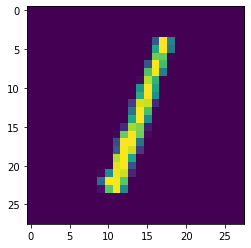

In [7]:
#Visualize each of the image and its label
images, labels = next(iter(trainloader))
img = images[0].view(28,28)
lab = labels[0]

img = (img+1)/2

plt.imshow(img)
lab.item()

Now we have imported the data, created Training and Test Set

We will now create our Neural Network model along with Optimizers and loss function

## Generator Architecture
1 input layer 

3 hidden layers with relu activation

1 output layer with tanh activation

We will input a latent vector of size 100

First layer will have input and output as (100, 4*16 =64)

Second layer : (64, 4*32 = 128)

Third layer : (128, 4*64 = 256)

Fourth Layer : (256, 512)

Output layer : (512, output = 784)
## Discriminator Architecture
1 input layer

3 hidden layers with relu activation

1 output layer with sigmoid activation

We will input an image of size 28*28 (784 unrolled)

Input layer : (784, 512)

FIrst Layer : (512,256)

Second layer : (256, 128)

Third Layer : (128, 32)

Output layer : (32, 1)

In [8]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_size = 4, output_size = 784):
        super().__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size*16)
        self.layer2 = nn.Linear(hidden_size*16, hidden_size*32)
        self.layer3 = nn.Linear(hidden_size*32, hidden_size*64)
        self.layer4 = nn.Linear(hidden_size*64, hidden_size*128)
        
        self.output = nn.Linear(hidden_size*128, output_size)
        
        self.dropout = nn.Dropout(p=0.2)
    
    #Input would be a batch_size*28*28 tensor
    def forward(self, x):
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x = F.relu(self.layer4(x))
        
        x = F.tanh(self.output(x))
        
        return x

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size, hidden_size = 4, output_size = 1):
        super().__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size*128)
        self.layer2 = nn.Linear(hidden_size*128, hidden_size*64)
        self.layer3 = nn.Linear(hidden_size*64, hidden_size*32)
        self.layer4 = nn.Linear(hidden_size*32, hidden_size*8)
        
        self.output = nn.Linear(hidden_size*8,output_size)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        
        x = x.view(-1, 784)
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x = F.relu(self.layer4(x))
        
        return F.sigmoid(self.output(x))

In [10]:
#Training function
def train(epochs = 10):
    
    discriminator = Discriminator(784)
    generator = Generator(100,4,784)

    if train_on_gpu == True:
        discriminator.cuda()
        generator.cuda()
    
    gen_optim = optim.SGD(generator.parameters(), lr = gen_lr)
    dis_optim = optim.SGD(discriminator.parameters(), lr = dis_lr)
    
    loss_fn_gen = nn.BCELoss()
    loss_fn_dis = nn.BCELoss()
    
    generator.train()
    discriminator.train()
        
    gen_loss = []
    dis_loss_real = []
    dis_loss_fake = []
    
    for i in range(epochs):
        running_loss_disc_real = 0
        running_loss_disc_fake = 0
        running_loss_gen = 0
        
        for real_images, labels in trainloader:
            
            label_zero = torch.zeros(len(labels))
            label_one = torch.ones(len(labels))
            
            if train_on_gpu == True:
                real_images = real_images.cuda()
                label_zero = label_zero.cuda()
                label_one = label_one.cuda()
            
            dis_optim.zero_grad()
            
            #Generate fake samples equal to that of batchsize
            #Normalize it to range of [-1,1] similar to real input images
            latent = torch.rand(len(labels), 100)
            latent = (latent-0.5)/0.5
    
            if train_on_gpu == True:
                latent = latent.cuda()
    
            fake = generator(latent)
            
            #Find loss for discriminator
            loss_disc_real = loss_fn_dis(discriminator(real_images),label_one)
            loss_disc_fake = loss_fn_dis(discriminator(fake),label_zero)
            loss_disc =  loss_disc_real + loss_disc_fake
            loss_disc.backward(retain_graph = True)
            
            dis_optim.step()
            
            gen_optim.zero_grad()
            
            #Find loss for generator
            loss_gen = loss_fn_gen(discriminator(fake),label_one)
            loss_gen.backward()
            
            gen_optim.step()
            
            running_loss_disc_real += loss_disc_real.item()
            running_loss_disc_fake += loss_disc_fake.item()
            running_loss_gen += loss_gen.item()
        
        print('Generator Loss after {} epoch is {} and Discriminator loss is {} on real images and {} on fake images'.format(i+1,running_loss_gen,running_loss_disc_real, running_loss_disc_fake))
        
        gen_loss.append(running_loss_gen)
        dis_loss_real.append(running_loss_disc_real)
        dis_loss_fake.append(running_loss_disc_fake)
    
    plt.plot(gen_loss,label = 'Generator Loss')
    plt.plot(dis_loss_real, label = 'Discriminator Loss Real')
    plt.plot(dis_loss_fake, label = 'Discriminator Loss Fake')
    plt.legend()
    plt.show()
    
    return generator, discriminator

Generator Loss after 1 epoch is 2536.4597502313554 and Discriminator loss is 97.96077202660672 on real images and 188.35725574940443 on fake images
Generator Loss after 2 epoch is 2823.703704930842 and Discriminator loss is 286.895600062795 on real images and 214.9733715262264 on fake images
Generator Loss after 3 epoch is 2918.8230471611023 and Discriminator loss is 253.6609225955326 on real images and 166.12215474806726 on fake images
Generator Loss after 4 epoch is 4409.282904744148 and Discriminator loss is 15.594518785699952 on real images and 20.246905781095847 on fake images
Generator Loss after 5 epoch is 6095.264954566956 and Discriminator loss is 0.2678710042627246 on real images and 2.304011850093957 on fake images
Generator Loss after 6 epoch is 3766.3293763548136 and Discriminator loss is 266.60760619633123 on real images and 174.245099957727 on fake images
Generator Loss after 7 epoch is 3137.458172917366 and Discriminator loss is 188.58928991205903 on real images and 106

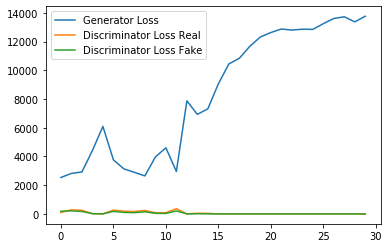

In [16]:
gen_lr = 0.02
dis_lr = 0.02
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(epoch)

Generator Loss after 1 epoch is 1210.8554687611759 and Discriminator loss is 524.4627885362752 on real images and 488.2327640866861 on fake images
Generator Loss after 2 epoch is 921.1878272891045 and Discriminator loss is 588.3991173431277 on real images and 560.7361562848091 on fake images
Generator Loss after 3 epoch is 910.4889005720615 and Discriminator loss is 590.9471036531031 on real images and 547.4070973545313 on fake images
Generator Loss after 4 epoch is 788.3005692064762 and Discriminator loss is 607.653265081346 on real images and 589.9102375805378 on fake images
Generator Loss after 5 epoch is 1010.0308953225613 and Discriminator loss is 548.6771929264069 on real images and 508.8961073309183 on fake images
Generator Loss after 6 epoch is 1186.58996707201 and Discriminator loss is 511.04178934078664 on real images and 444.8436367549002 on fake images
Generator Loss after 7 epoch is 1290.232186973095 and Discriminator loss is 515.5886303894222 on real images and 444.596925

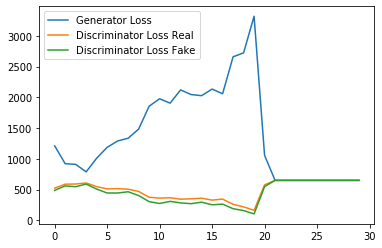

In [18]:
gen_lr = 0.1
dis_lr = 0.1
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(epoch)

In [12]:
def test_model(discriminator, generator, no_images = 30):
    with torch.no_grad():
        generator.eval()
        latent_result = (torch.rand(no_images,100) - 0.5)/0.5
        if train_on_gpu == True:
            latent_result = latent_result.cuda()

        res_images = generator(latent_result)
        
        k = int(no_images/5)
        
        fig, axes = plt.subplots(5,k, figsize = (30,30))

        for i in range(5):
            for j in range(k):
                img_show = res_images[i*k + j]
                img_show = ((img_show.view(28,28)+1)/2).detach().cpu().data.numpy()
                axes[i][j].imshow(img_show)

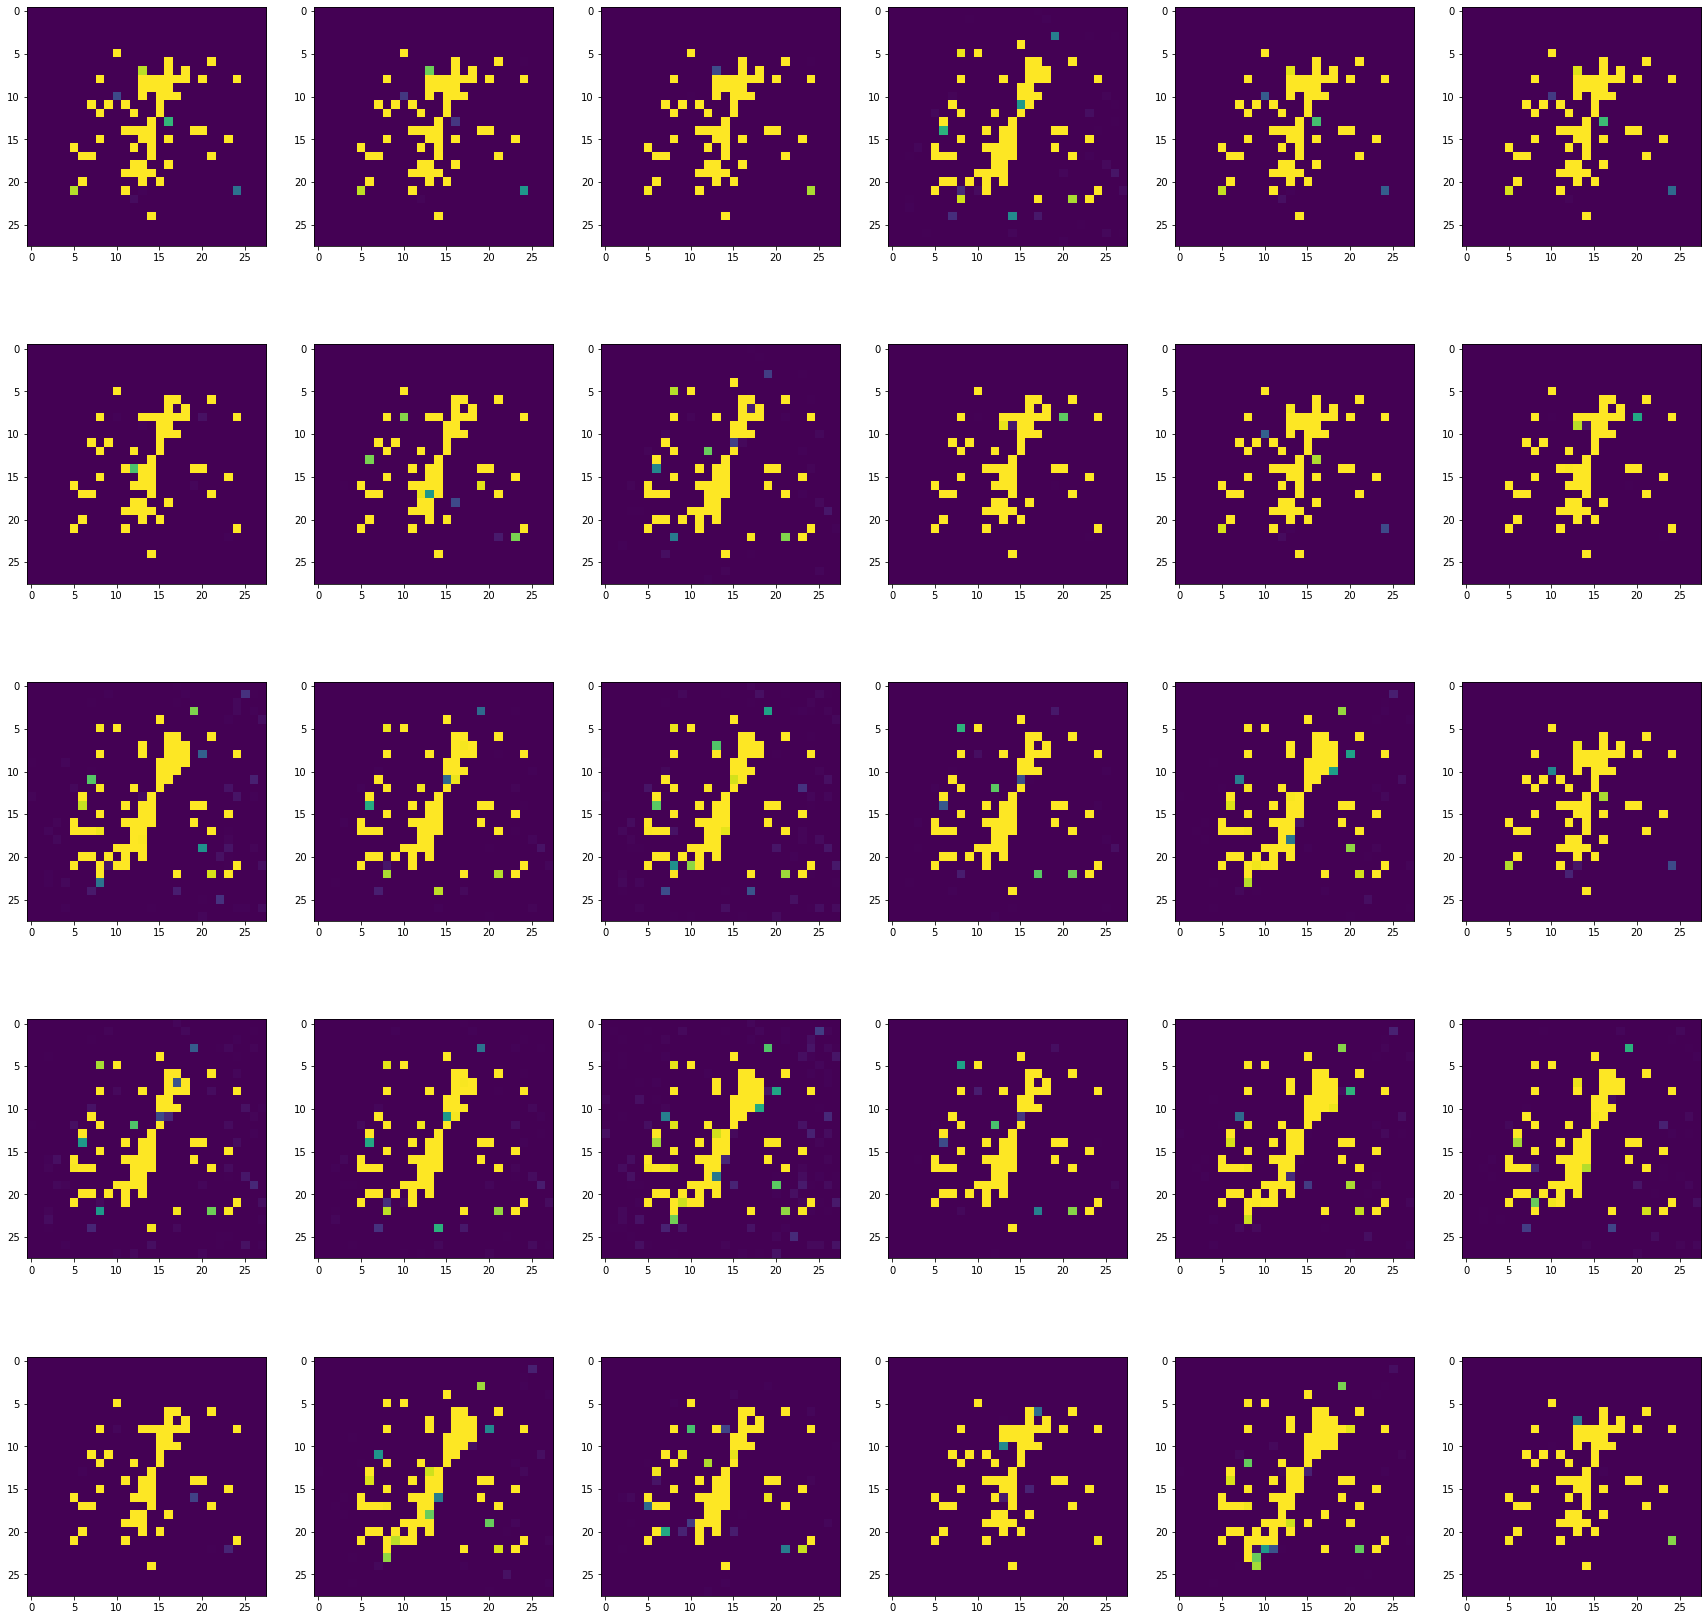

In [19]:
test_model(discriminator, generator)